<a href="https://colab.research.google.com/github/ashkwart/Ashley-Website/blob/main/Week9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%config InlineBackend.figure_formats = ["retina"]

In [2]:
!pip install -q osmnx descartes scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 kB 3.2 MB/s eta 0:00:00


In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import pandas as pd
import matplotlib.lines as mlines

from tqdm import tqdm
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon
from joblib import Parallel, delayed

# change to true to use local data
use_local_data=True

In [4]:
!curl -OL https://github.com/PUBPOL-2130/notebooks/raw/refs/heads/main/data/nyc_walk.graphml.zip
!curl -OL https://github.com/PUBPOL-2130/notebooks/raw/refs/heads/main/data/nyc_bike.graphml.zip
!curl -OL https://github.com/PUBPOL-2130/notebooks/raw/refs/heads/main/data/nyc_drive.graphml.zip
!unzip nyc_walk.graphml.zip
!unzip nyc_bike.graphml.zip
!unzip nyc_drive.graphml.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 34.7M  100 34.7M    0     0  60.9M      0 --:--:-- --:--:-- --:--:-- 60.9M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 11.2M  100 11.2M    0     0  16.0M      0 --:--:-- --:--:-- --:--:-- 16.0M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 9283k  100 9283k    0     0  16.9M      0 --:--:-- --:--:-- --:--:-- 50.9M
Archive:  nyc_walk.graphml.zip
  inflating: nyc_walk

# Cities and Transit
This week's notebook will be focused on cities and transit. We'll focus on a variety of transit-related datasets from the [NYC](https://data.cityofnewyork.us/browse?sortBy=relevance&pageSize=20&category=Transportation&page=1) Open Data Portal (comparatively, you can also check out the [NY State](https://data.ny.gov/browse?category=Transportation&utf8=%E2%9C%93&sortBy=relevance&page=1&pageSize=20) Open Data Portal). Explore these sites on your own as inspiration for your final projects!

A lot of transportation data can be visualized using networks and flow maps, similar to previous weeks. For example, we can examine [Yellow Taxi Trips](https://data.cityofnewyork.us/Transportation/2023-Yellow-Taxi-Trip-Data/4b4i-vvec/about_data) between pairs of NYC neighborhoods or look at [MTA daily ridership](https://data.ny.gov/Transportation/MTA-Daily-Ridership-Data-2020-2025/vxuj-8kew/about_data) between stations.

However, *measuring distance* is another kind of question that's useful to study in the context of transportation --- relevant to questions like:
* how many subway stations are located within 10 minutes of a park?
* how does voter access to a poll site vary by neighborhood?

While conventional straight-line distance measurements may provide approximate answers to these questions, a better and more realistic approach involves analyzing distances via the *street network*.

In this notebook, we'll discuss open-source approaches to calculating *network distances*, which are distances measured along a network (e.g., a street network). We'll also learn how to make an [isochrone map](https://en.wikipedia.org/wiki/Isochrone_map), which is a type of map that depicts all the area accessible within a given travel time.

In [5]:
subway_stations = gpd.read_file(
    "https://data.ny.gov/resource/39hk-dx4f.geojson?$limit=100000"
)
subway_stations.head()

,station_id,north_direction_label,line,daytime_routes,complex_id,division,ada_southbound,gtfs_stop_id,structure,ada_notes,stop_name,gtfs_longitude,ada_northbound,ada,south_direction_label,cbd,borough,gtfs_latitude,geometry
0,1,Last Stop,Astoria,N W,1,BMT,0,R01,Elevated,None,Astoria-Ditmars Blvd,-73.912034,0,0,Manhattan,False,Q,40.775036,POINT (-73.91203 40.77504)
1,2,Astoria,Astoria,N W,2,BMT,1,R03,Elevated,None,Astoria Blvd,-73.917843,1,1,Manhattan,False,Q,40.770258,POINT (-73.91784 40.77026)
2,3,Astoria,Astoria,N W,3,BMT,0,R04,Elevated,None,30 Av,-73.921479,0,0,Manhattan,False,Q,40.766779,POINT (-73.92148 40.76678)
3,4,Astoria,Astoria,N W,4,BMT,0,R05,Elevated,None,Broadway,-73.925508,0,0,Manhattan,False,Q,40.76182,POINT (-73.92551 40.76182)
4,5,Astoria,Astoria,N W,5,BMT,0,R06,Elevated,None,36 Av,-73.929575,0,0,Manhattan,False,Q,40.756804,POINT (-73.92958 40.7568)


In [6]:
parks = gpd.read_file(
    "https://nycopendata.socrata.com/resource/enfh-gkve.geojson?$limit=100000"
)
parks.head()

,jurisdiction,mapped,zipcode,acres,location,nys_assembly,councildistrict,typecategory,us_congress,eapply,...,gisobjid,signname,address,permitparent,class,nys_senate,permitdistrict,borough,waterfront,geometry
0,DPR,False,"10027, 10031",13.35,"Riverside Dr to Henry Hudson Pkwy, W 153 St",71,7,Neighborhood Park,13,Riverside Park,...,100005045,Riverside Park,675 RIVERSIDE DRIVE,M-14,PARK,30,M-14,M,0.0,"MULTIPOLYGON (((-73.95194 40.8276, -73.95191 4..."
1,DPR,True,10032,0.774,"Broadway, St Nicholas Av, W 166 St To W 168 St",72,10,Triangle/Plaza,13,Mitchell Square,...,100005043,Mitchel Square,3962 BROADWAY,M-12,PARK,31,M-12A,M,0.0,"MULTIPOLYGON (((-73.93999 40.83969, -73.93998 ..."
2,DPR,True,10460,0.183,E 174 St bet. Bryant Av and Longfellow Av,85,17,Neighborhood Park,14,Eae J Mitchell Park,...,100005002,Eae J Mitchell Park,995 EAST 174 STREET,X-03,PARK,32,X-03,X,0.0,"MULTIPOLYGON (((-73.88417 40.8365, -73.8845 40..."
3,DPR,True,10459,1.2,Boone Av bet. W Farms Rd and Freeman St,85,17,Playground,14,Daniel Boone Playground,...,100005013,Daniel Boone Playground,1340 WEST FARMS ROAD,X-03,PARK,32,X-03,X,0.0,"MULTIPOLYGON (((-73.88602 40.8286, -73.88601 4..."
4,DPR,False,10451,0.227,Elton Ave. at E. 160 St.,79,17,Garden,15,Jardin de la Roca,...,100003876,Jardin de la Roca,843 ELTON AVENUE,X-03,PARK,32,X-03,X,0.0,"MULTIPOLYGON (((-73.91313 40.82289, -73.91279 ..."


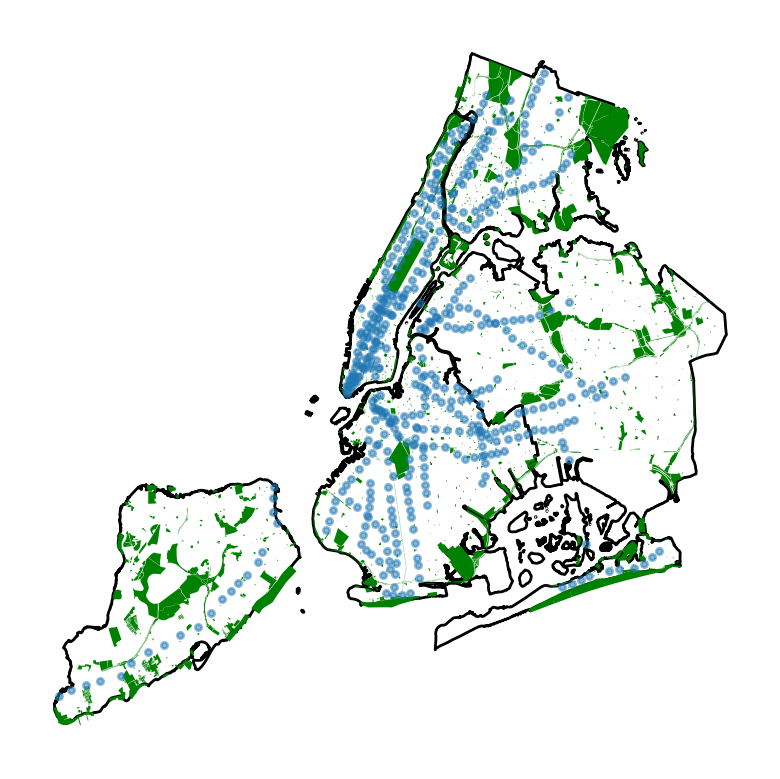

In [7]:
# note: here we're just pulling a file of all nyc boroughs to provide context on our map
boros = gpd.read_file(
    "https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Borough_Boundary/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson"
)
ax = boros.plot(facecolor="none")
parks.plot(ax=ax, facecolor="green")
subway_stations.plot(ax=ax, alpha=0.5, markersize=5)
ax.set_axis_off();

Let's look at how many subway stations are located within 10 minutes of a park *on average*. 10 minutes walking distance is roughly a half-mile, so let's examine the average number of parks within 0.5 miles from a park.

A simple way to do this is to create a [buffer](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.buffer.html) in Geopandas, and apply this to the park data. A buffer will return a new geometry containing the original geometry and all the area within a given distance from the original geometry.

First, to specify the correct distance we'll need to make sure that we're in the right projected coordinate system. We'll use [EPSG: 2263](https://spatialreference.org/ref/epsg/2263/), which is a standard projected coordinate system for the NYC area and uses feet as the unit of measurement.

In [8]:
print(parks.crs)
parks_proj = parks.to_crs(2263)
# convert to projected coordinate system!
print(parks_proj.crs)

EPSG:4326
EPSG:2263


In [9]:
# create a buffer of 2640 feet (=1/2 a mile)
parks_buffer = parks_proj.copy()
parks_buffer["geometry"] = parks_proj.buffer(2640)

We can visualize our buffer regions around each park. Dark green denotes the buffer, light green denotes the actual park.

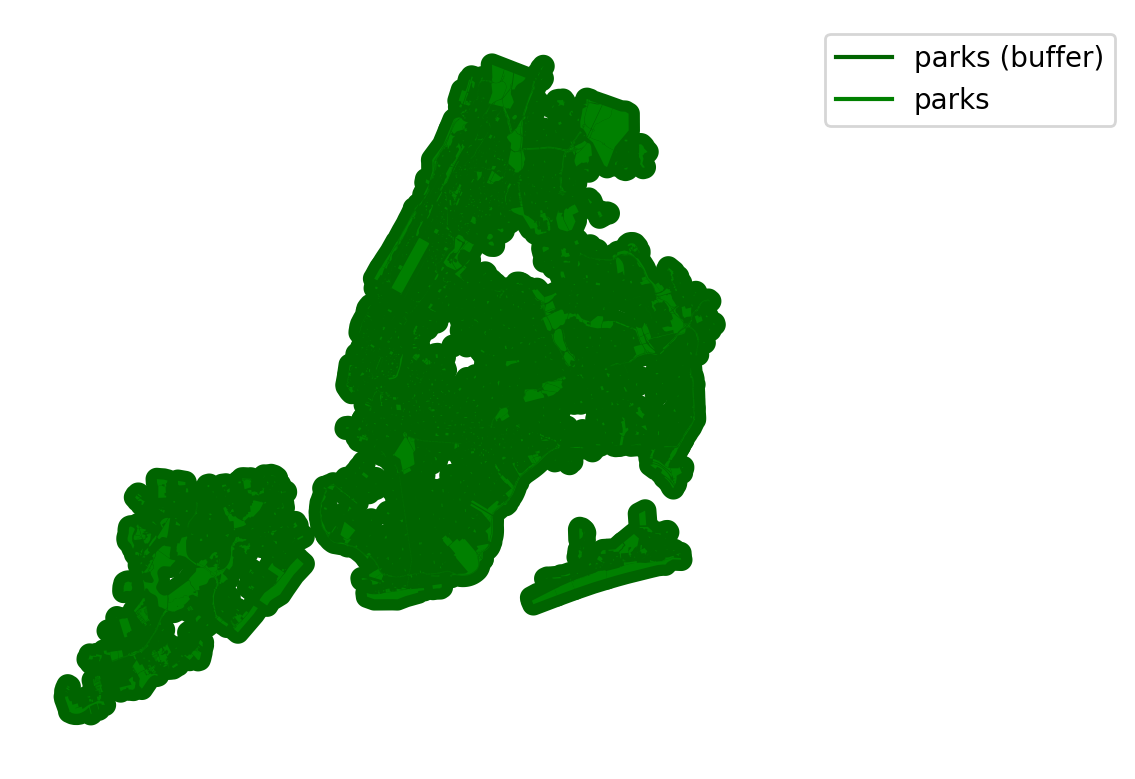

In [10]:
ax = parks_buffer.plot(color="darkgreen")
parks_proj_plot = parks_proj.plot(ax=ax, color="green")

# defining legend style and data
parks_buffer_handle = mlines.Line2D([], [], color="darkgreen", label="parks (buffer)")
parks_handle = mlines.Line2D([], [], color="green", label="parks")

ax.legend(
    handles=[parks_buffer_handle, parks_handle],
    loc="upper right",
    bbox_to_anchor=(1.5, 1),
)
ax.set_axis_off();

Now, we'll use a [spatial join](https://geopandas.org/en/stable/gallery/spatial_joins.html) to identify the points that intersect the parks buffer. A spatial join works similar to a regular join, but it uses the concept of a spatial intersection (or overlap) to join the geodataframes rather than an index column. You can think of it as spatially intersecting two geodatframes and returning shared information from both geodataframes, using the geometries of the first.

In [11]:
# check the crs again!
print(subway_stations.crs)
subway_stations = subway_stations.to_crs(2263)
print(subway_stations.crs)

EPSG:4326
EPSG:2263


We want to dissolve the `parks_buffer` geodataframe so that it is only one MultiPolygon object.

We'll also create a new variable called `10_min_from_park` that we will use later to determine whether any subway stations intersect `parks_buffer`.

In [12]:
# dissolve the overlapping polygons
parks_buffer_diss = parks_buffer.dissolve()
# we will use this to see what's not intersecting with our park buffer zone
parks_buffer_diss["10_min_from_park"] = 1

Let's visualize our results! The resulting *looks* the same but the resulting geodataframe looks a little different.

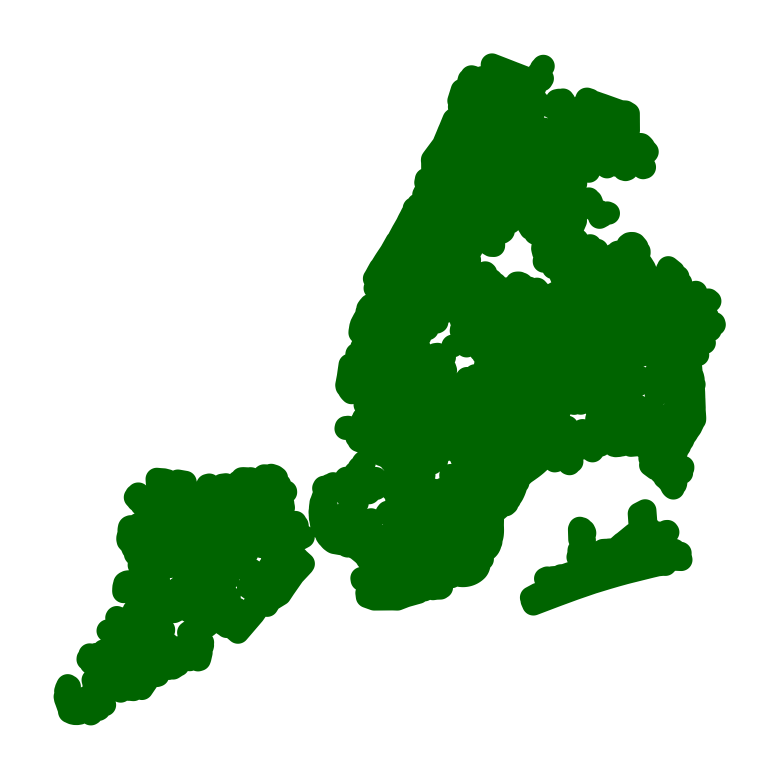

In [13]:
ax = parks_buffer_diss.plot(color="darkgreen")
ax.set_axis_off();

In [14]:
parks_buffer_diss

,geometry,jurisdiction,mapped,zipcode,acres,location,nys_assembly,councildistrict,typecategory,us_congress,...,gisobjid,signname,address,permitparent,class,nys_senate,permitdistrict,borough,waterfront,10_min_from_park
0,"MULTIPOLYGON (((910737.977 121932.255, 910656....",DPR,False,"10027, 10031",13.35,"Riverside Dr to Henry Hudson Pkwy, W 153 St",71,7,Neighborhood Park,13,...,100005045,Riverside Park,675 RIVERSIDE DRIVE,M-14,PARK,30,M-14,M,0.0,1


Now we implement the spatial join. We'll specify a left join because we do want to know which subway stations do *not* intersect with parks buffer region.

In [15]:
subway_stations_sjoin = subway_stations.sjoin(parks_buffer_diss, how="left")
subway_stations_sjoin.head()

,station_id,north_direction_label,line,daytime_routes,complex_id,division,ada_southbound,gtfs_stop_id,structure,ada_notes,...,gisobjid,signname,address,permitparent,class,nys_senate,permitdistrict,borough_right,waterfront,10_min_from_park
0,1,Last Stop,Astoria,N W,1,BMT,0,R01,Elevated,None,...,100005045,Riverside Park,675 RIVERSIDE DRIVE,M-14,PARK,30,M-14,M,0.0,1.0
1,2,Astoria,Astoria,N W,2,BMT,1,R03,Elevated,None,...,100005045,Riverside Park,675 RIVERSIDE DRIVE,M-14,PARK,30,M-14,M,0.0,1.0
2,3,Astoria,Astoria,N W,3,BMT,0,R04,Elevated,None,...,100005045,Riverside Park,675 RIVERSIDE DRIVE,M-14,PARK,30,M-14,M,0.0,1.0
3,4,Astoria,Astoria,N W,4,BMT,0,R05,Elevated,None,...,100005045,Riverside Park,675 RIVERSIDE DRIVE,M-14,PARK,30,M-14,M,0.0,1.0
4,5,Astoria,Astoria,N W,5,BMT,0,R06,Elevated,None,...,100005045,Riverside Park,675 RIVERSIDE DRIVE,M-14,PARK,30,M-14,M,0.0,1.0


In [16]:
# missing values of our indicator column indicate that it didn't intersect with the park buffer zone
pct_10_min_park = subway_stations_sjoin["10_min_from_park"].notna().mean() * 100
print(f"{pct_10_min_park.round(2)}% of subway stations are within 10 minutes of a park")

99.8% of subway stations are within 10 minutes of a park


Using the missing values of the column we defined previously (`10_min_from_park`), we can see that almost all subway stations are within 10 minutes of a park! There's just one subway station that isn't, and we investigate that one below. It looks like it's an A train station in Queens.

In [17]:
# what is the one subway station that is not within 10 minutes from a park?
subway_stations_sjoin.loc[
    subway_stations_sjoin["10_min_from_park"].isna(),
    ["station_id", "daytime_routes", "division", "borough_left"],
]

,station_id,daytime_routes,division,borough_left
195,195,A,IND,Q


Creating a buffer assumes that straight-line distance is sufficient. But, realistically, straight-line distance is a strong assumption.

Now, we'll try calculating the number of subway stations within 10 minutes from a park but we'll calculate *network distance* using the street network.

## Download the street network

We'll download the street network using OSMnx. OSMnx retrieves the place boundaries of the city from the [Nominatim API](https://nominatim.org/), which uses OpenStreetMap data. It retrieves the street networks via the [Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API) (another API using OpenStreetMap). Then, it constructs a graphical model where nodes represent intersections and edges represent streets.

OSMnx leverages [NetworkX](https://networkx.org/documentation/stable/) for constructing graphs, which we've seen in previous notebooks.

It also provides functions for converting between graphs and geodataframes.

In [18]:
# setup, we'll load data for NYC (try changing this on your own!)
place = "New York, NY, USA"
network_type = "walk"  # you can also try bike, and drive -- we'll look at this later
trip_times = [1, 5, 10]  # minutes

In [19]:
# download the street network, this may take a few minutes
# if use local data, load data from unzipped graphml file
if use_local_data:
  G = ox.io.load_graphml(filepath='./nyc_walk.graphml')
else:
  G = ox.graph_from_place(place, network_type=network_type)

In [20]:
# project the graph -- important!!
G = ox.project_graph(G, to_crs=2263)

In [21]:
# store the nodes as a geodataframe
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
gdf_nodes.head()

,y,x,street_count,highway,ref,railway,junction,geometry
osmid,,,,,,,,
30807314,227359.781611,994335.822253,4,NaN,NaN,NaN,NaN,POINT (994335.822 227359.782)
2057103273,226874.531890,994265.522974,4,NaN,NaN,NaN,NaN,POINT (994265.523 226874.532)
6579409036,227473.736562,994488.569520,3,NaN,NaN,NaN,NaN,POINT (994488.57 227473.737)
4303265016,227339.718476,994363.908636,3,NaN,NaN,NaN,NaN,POINT (994363.909 227339.718)
1203806304,227402.902773,994297.176349,4,crossing,NaN,NaN,NaN,POINT (994297.176 227402.903)


In [22]:
# store the edges as a geodataframe
gdf_edges = ox.graph_to_gdfs(G, nodes=False, edges=True).reset_index()
gdf_edges.head()

,u,v,key,osmid,highway,oneway,reversed,length,geometry,name,...,ref,access,junction,service,bridge,width,tunnel,est_width,area,landuse
0,30807314,2057103273,0,46613689,bridleway,False,False,159.255042,"LINESTRING (994335.822 227359.782, 994328.847 ...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,30807314,6579409036,0,46613689,bridleway,False,True,58.144181,"LINESTRING (994335.822 227359.782, 994344.736 ...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,30807314,4303265016,0,147089927,footway,False,False,10.509449,"LINESTRING (994335.822 227359.782, 994349.893 ...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,30807314,1203806304,0,147089927,footway,False,True,17.645411,"LINESTRING (994335.822 227359.782, 994307.648 ...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2057103273,1203806190,0,1081028185,footway,False,True,15.480750,"LINESTRING (994265.523 226874.532, 994315.702 ...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# get the nearest street nodes from the park centroids
park_nodes = ox.nearest_nodes(G, parks_proj.centroid.x, parks_proj.centroid.y)

Another way you could do this is to grab any street that intersects within a 100-foot buffer around the parks. Note: the default behavior of `sjoin` is to do an inner join.

In [24]:
parks_proj_buffer = parks_proj.copy()
parks_proj_buffer["geometry"] = parks_proj_buffer["geometry"].buffer(100)
gdf_edges_park = gdf_edges.sjoin(parks_proj_buffer)
gdf_edges_park.head()

,u,v,key,osmid,highway,oneway,reversed,length,geometry,name,...,omppropid,gisobjid,signname,address,permitparent,class,nys_senate,permitdistrict,borough,waterfront
0,30807314,2057103273,0,46613689,bridleway,False,False,159.255042,"LINESTRING (994335.822 227359.782, 994328.847 ...",NaN,...,M010,100004894,Central Park,1000 5 AVENUE,M-13,PARK,283047,M-13,M,0.0
1,30807314,6579409036,0,46613689,bridleway,False,True,58.144181,"LINESTRING (994335.822 227359.782, 994344.736 ...",NaN,...,M010,100004894,Central Park,1000 5 AVENUE,M-13,PARK,283047,M-13,M,0.0
2,30807314,4303265016,0,147089927,footway,False,False,10.509449,"LINESTRING (994335.822 227359.782, 994349.893 ...",NaN,...,M010,100004894,Central Park,1000 5 AVENUE,M-13,PARK,283047,M-13,M,0.0
3,30807314,1203806304,0,147089927,footway,False,True,17.645411,"LINESTRING (994335.822 227359.782, 994307.648 ...",NaN,...,M010,100004894,Central Park,1000 5 AVENUE,M-13,PARK,283047,M-13,M,0.0
4,2057103273,1203806190,0,1081028185,footway,False,True,15.480750,"LINESTRING (994265.523 226874.532, 994315.702 ...",NaN,...,M010,100004894,Central Park,1000 5 AVENUE,M-13,PARK,283047,M-13,M,0.0


In [25]:
gdf_edges_park.shape

(203594, 56)

Let's plot what's returned via both approaches: `ox.nearest_nodes()` and intersecting streets with a 100-foot buffer.

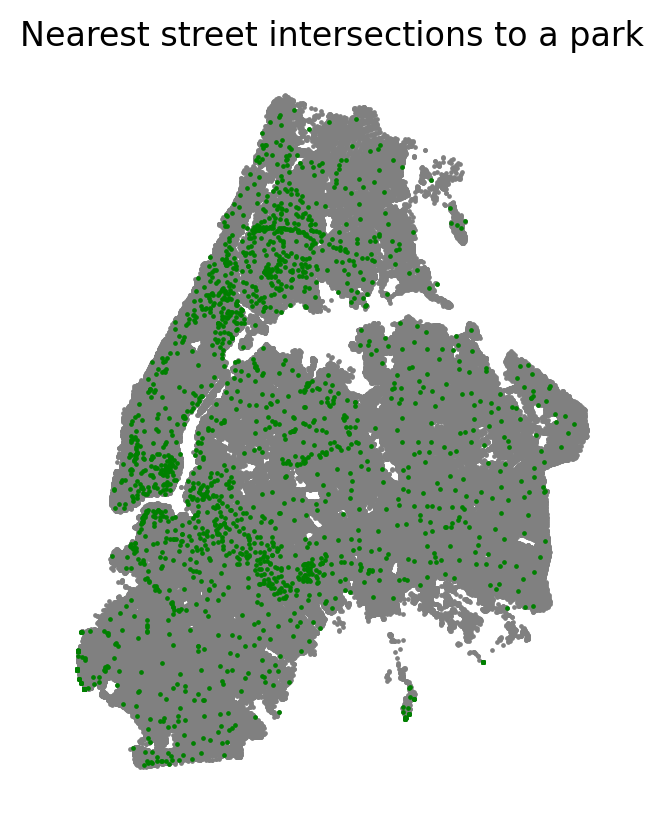

In [26]:
ax = gdf_nodes.plot(color="gray", markersize=0.5)
gdf_nodes.loc[park_nodes].plot(ax=ax, color="green", markersize=0.5)
ax.set_title("Nearest street intersections to a park")
ax.set_axis_off();

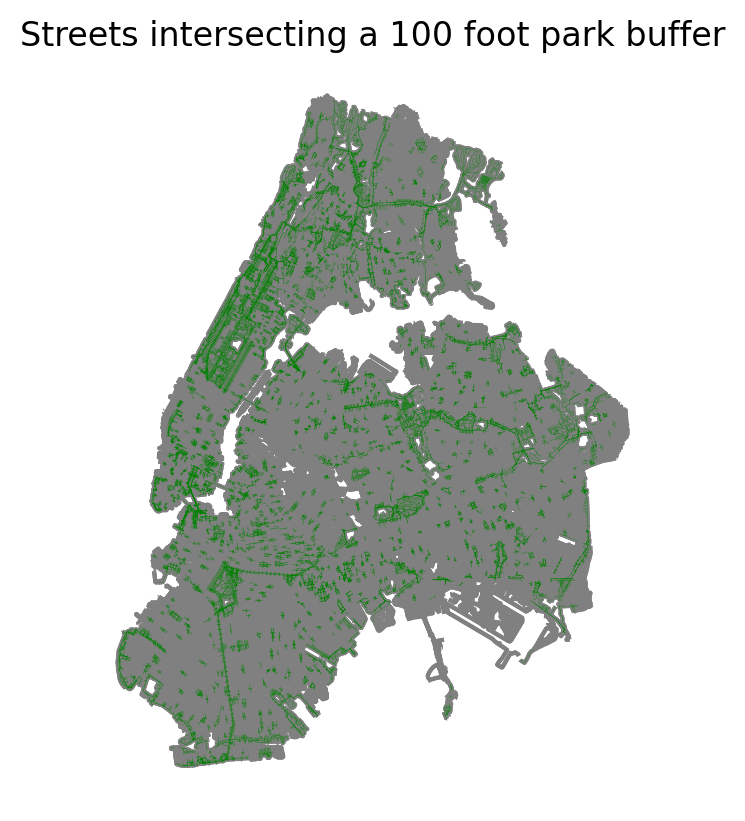

In [27]:
ax = gdf_edges.plot(color="gray", markersize=0.5)
gdf_edges_park.plot(ax=ax, color="green", linewidth=0.05)
ax.set_title("Streets intersecting a 100 foot park buffer")
ax.set_axis_off();

Now, we'll add edge information that estimates the amount of time required to traverse each edge. We'll assume that the average person walks **276** feet per minute.

In [28]:
avg_feet_per_minute = 276  # you can change this!

for u, v, k, data in G.edges(data=True, keys=True):
    data["length_ft"] = data["length"] * 3.28084  # osmnx internal units are meters
    data["time"] = data["length_ft"] / (
        avg_feet_per_minute
    )  # divide by feet per minute

## How far can you walk on foot within each time?

In [29]:
# define colors for each isochrone
iso_colors = ["darkgreen", "green", "lightgreen"]
iso_colors

# color the nodes according to isochrone then plot the street network
node_colors = {}
for park_node in tqdm(park_nodes):
    for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
        subgraph = nx.ego_graph(G, park_node, radius=trip_time, distance="time")
        for node in subgraph.nodes():
            node_colors[node] = color

100%|██████████| 2052/2052 [01:38<00:00, 20.74it/s]


Now, we'll plot the street *nodes* that are within 1, 5 and 10 minutes of a park

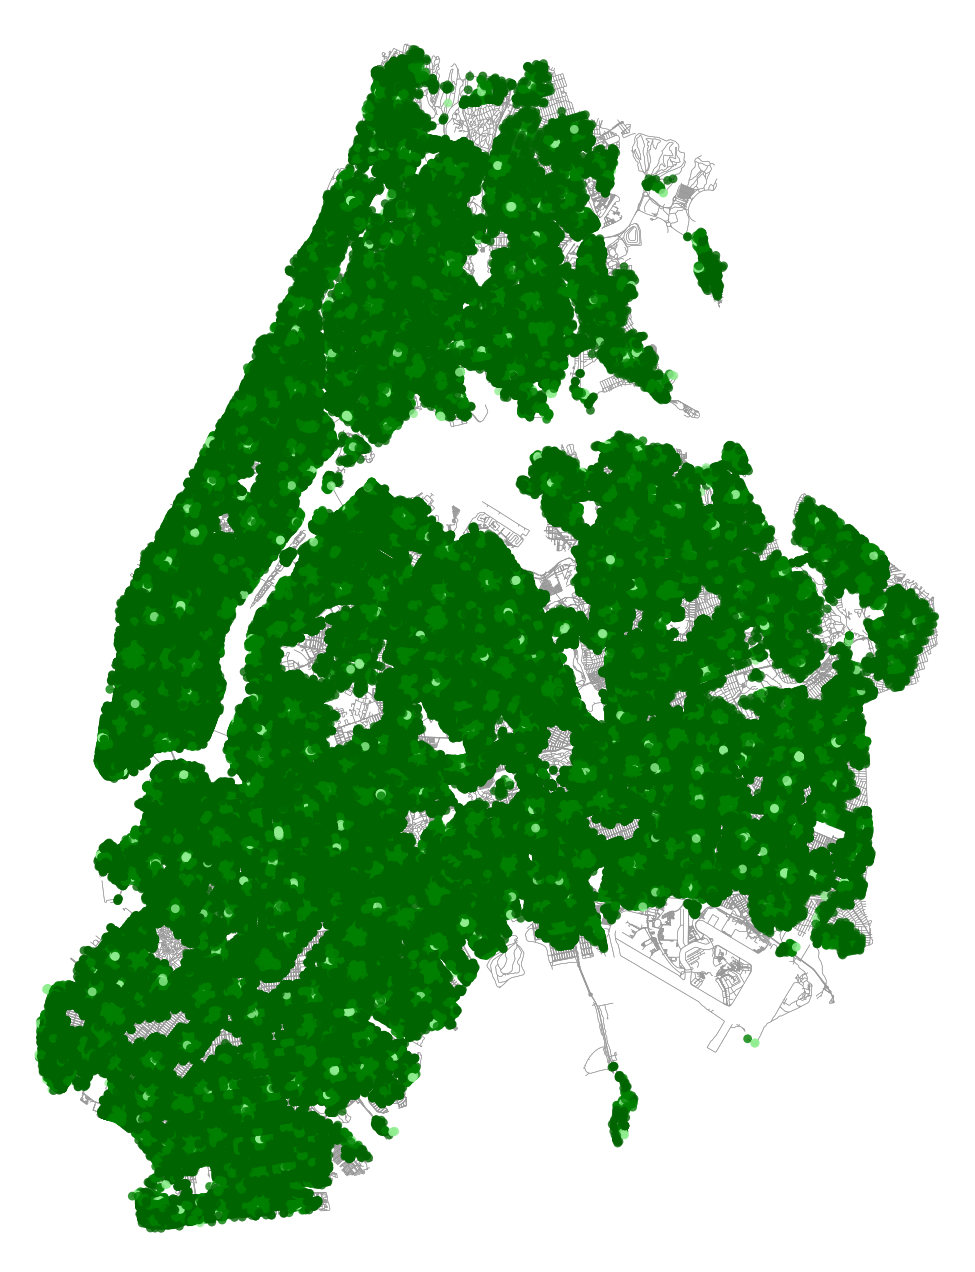

In [30]:
nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
ns = [10 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    node_zorder=2,
    bgcolor="w",
    edge_linewidth=0.2,
    edge_color="#999999",
)

## Produce Isochrones

Isochrone approaches:
* Approach 1: Distance "as the crow flies"
* Approach 2: Network Distance
    - Modes of visualization:
        - Use convex hull
        - Create a buffer along street edges


We'll now explore two different ways of visualizing isochrones: convex hull and creating a buffer along street edges. We'll focus on generating isochrones from a single location, which you can try changing yourself.

Several functions below make use of code originally provided in this [example notebook](https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb) on using OSMnx to produce isochrones. The functions have been modified and simplified here to focus on the specific content (i.e., parks and subways).

First, we select a location of interest. In this case, we'll investigate the subway station that was shown to be far away from any nearby parks. You can use any other point that might be of interest, as long as it's in the same projected coordinate system

In [50]:
selected_subway_station = subway_stations_sjoin[
    subway_stations_sjoin["station_id"] == "4"
]
selected_subway_station

,station_id,north_direction_label,line,daytime_routes,complex_id,division,ada_southbound,gtfs_stop_id,structure,ada_notes,...,gisobjid,signname,address,permitparent,class,nys_senate,permitdistrict,borough_right,waterfront,10_min_from_park
3,4,Astoria,Astoria,N W,4,BMT,0,R05,Elevated,None,...,100005045,Riverside Park,675 RIVERSIDE DRIVE,M-14,PARK,30,M-14,M,0.0,1.0


We'll examine this first using distance "as the crow flies" -- i.e., we'll calculate several buffer regions around the point of interest.

In [51]:
distances = [
    avg_feet_per_minute * i for i in trip_times
]  # convert trip time to distance in feet
buffer_gdf_list = []
for dist, trip_time in zip(distances, trip_times):
    subway_buffer = gpd.GeoDataFrame(
        geometry=selected_subway_station.buffer(dist), crs=2263
    )
    subway_buffer = subway_buffer.assign(trip_time=trip_time)
    buffer_gdf_list.append(subway_buffer)

In [52]:
# create a geodataframe with all of the buffers
buffer_gdf = pd.concat(buffer_gdf_list)
buffer_gdf

,geometry,trip_time
3,"POLYGON ((1005162.048 216837.071, 1005160.719 ...",1
3,"POLYGON ((1006266.048 216837.071, 1006259.403 ...",5
3,"POLYGON ((1007646.048 216837.071, 1007632.757 ...",10


Next, we'll create isochrones using *network distances.* We'll represent these first using convex hulls.

In [53]:
# identify the closest node on the street network
closest_node = ox.nearest_nodes(
    G, selected_subway_station.geometry.x, selected_subway_station.geometry.y
)
closest_node

array([3576165300])

In [54]:
# make the isochrone polygons, using convex hull
# store the isochrone polys in a dictionary
isochrone_polys = {x: [] for x in trip_times}
for park_node in tqdm(closest_node):  # note: this loop can also take in a list of nodes
    for trip_time in sorted(trip_times, reverse=True):
        # creates a subgraph based on trip time
        subgraph = nx.ego_graph(G, park_node, radius=trip_time, distance="time")
        # identifes all the points in the subgraph
        node_points = [
            Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)
        ]
        # creates a polygon using convex hull
        bounding_poly = gpd.GeoSeries(node_points).union_all().convex_hull
        isochrone_polys[trip_time].append(bounding_poly)
isochrone_polys;

100%|██████████| 1/1 [00:00<00:00, 15.60it/s]


In [55]:
# create a geodataframe of convex hulls
isochrone_gdf_list = [
    gpd.GeoDataFrame(geometry=isochrone_polys[trip_time], crs=2263).assign(
        trip_time=trip_time
    )
    for trip_time in trip_times
]
isochrone_gdf = pd.concat(isochrone_gdf_list)
isochrone_gdf

,geometry,trip_time
0,"POLYGON ((1004933.036 216700.778, 1004871.671 ...",1
0,"POLYGON ((1004838.901 215822, 1004628.581 2158...",5
0,"POLYGON ((1004177.283 214643.123, 1004115.554 ...",10


In [56]:
# for plotting, create a subgraph that is just the street grid surrounding the pt
queens_nodes = gdf_nodes.clip(isochrone_gdf.buffer(5280)).index
G_queens = G.subgraph(queens_nodes)
G_queens;

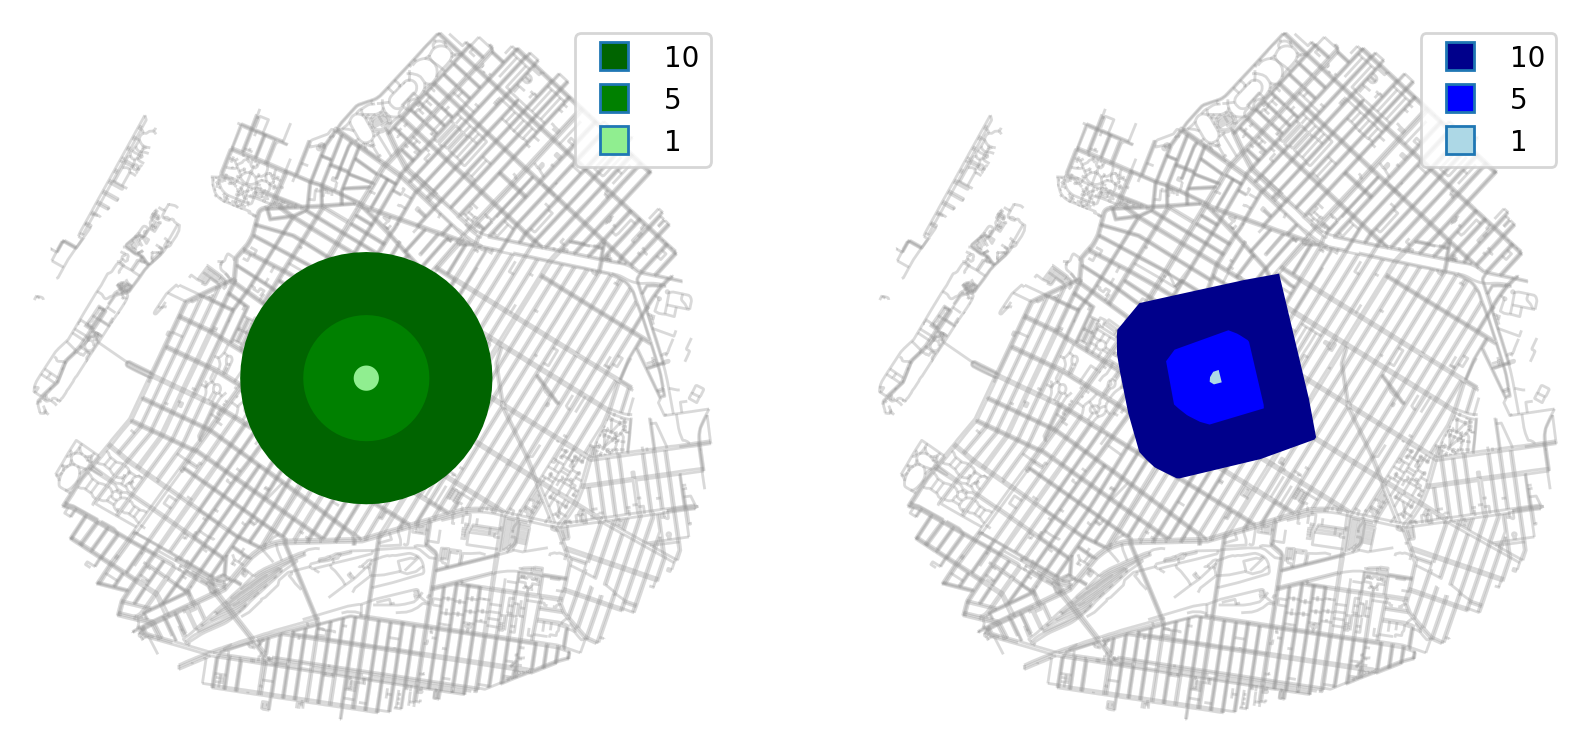

In [65]:
buffer_colors = ["darkgreen", "green", "lightgreen"]
iso_colors = ["darkblue", "blue", "lightblue"]

# plot the network then add isochrones
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

for ax in axes:
    ox.plot_graph(
        G_queens,
        ax=ax,
        show=False,
        close=False,
        edge_color="#999999",
        edge_alpha=0.2,
        node_size=0,
        bgcolor="w",
    )

for trip_time, color1, color2 in zip(
    sorted(trip_times, reverse=True), buffer_colors, iso_colors
):
    buffer_gdf[buffer_gdf["trip_time"] == trip_time].plot(ax=axes[0], color=color1)
    isochrone_gdf[isochrone_gdf["trip_time"] == trip_time].plot(
        ax=axes[1], color=color2
    )

for ax, color_list in zip(axes, [buffer_colors, iso_colors]):
    # adding the legend
    lines = [
        mlines.Line2D(
            [0], [0], linestyle="none", marker="s", markersize=10, markerfacecolor=color
        )
        for color in color_list
    ]
    labels = sorted(trip_times, reverse=True)
    ax.legend(lines, labels)
ax.set_axis_off()
plt.savefig("astoria_isochrone.png")
plt.show()

Now, we'll plot the isochrones as buffers around the street grid.

In [58]:
def create_edge_lines(G, nodes_gdf, n_fr, n_to):
    f = nodes_gdf.loc[n_fr].geometry
    t = nodes_gdf.loc[n_to].geometry
    return G.get_edge_data(n_fr, n_to)[0].get("geometry", LineString([f, t]))


def make_iso_polys(node_list, G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = {x: [] for x in trip_times}
    for nd in tqdm(node_list):
        for trip_time in sorted(trip_times, reverse=True):
            subgraph = nx.ego_graph(G, nd, radius=trip_time, distance="time")
            node_points = [
                Point((data["x"], data["y"]))
                for node, data in subgraph.nodes(data=True)
            ]
            nodes_gdf = gpd.GeoDataFrame({"id": subgraph.nodes()}, geometry=node_points)
            nodes_gdf = nodes_gdf.set_index("id")

            edge_lines = []
            for n_fr, n_to in subgraph.edges():
                edge_lookup = create_edge_lines(G, nodes_gdf, n_fr, n_to)
                edge_lines.append(edge_lookup)

            n = nodes_gdf.buffer(node_buff).geometry
            e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
            all_gs = list(n) + list(e)
            new_iso = gpd.GeoSeries(all_gs).union_all()
            isochrone_polys[trip_time].append(new_iso)
    return isochrone_polys

isochrone_polys = make_iso_polys(
    closest_node, G, edge_buff=25, node_buff=0, infill=True
)

100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


In [59]:
# create dataframe of buffer regions
isochrone_buffer_gdf_list = []
for trip_time in trip_times:
    isochrone_buffer_gdf_list += [
        gpd.GeoDataFrame(geometry=isochrone_polys[trip_time], crs=2263).assign(
            trip_time=trip_time
        )
    ]
isochrone_buffer_gdf = pd.concat(isochrone_buffer_gdf_list)

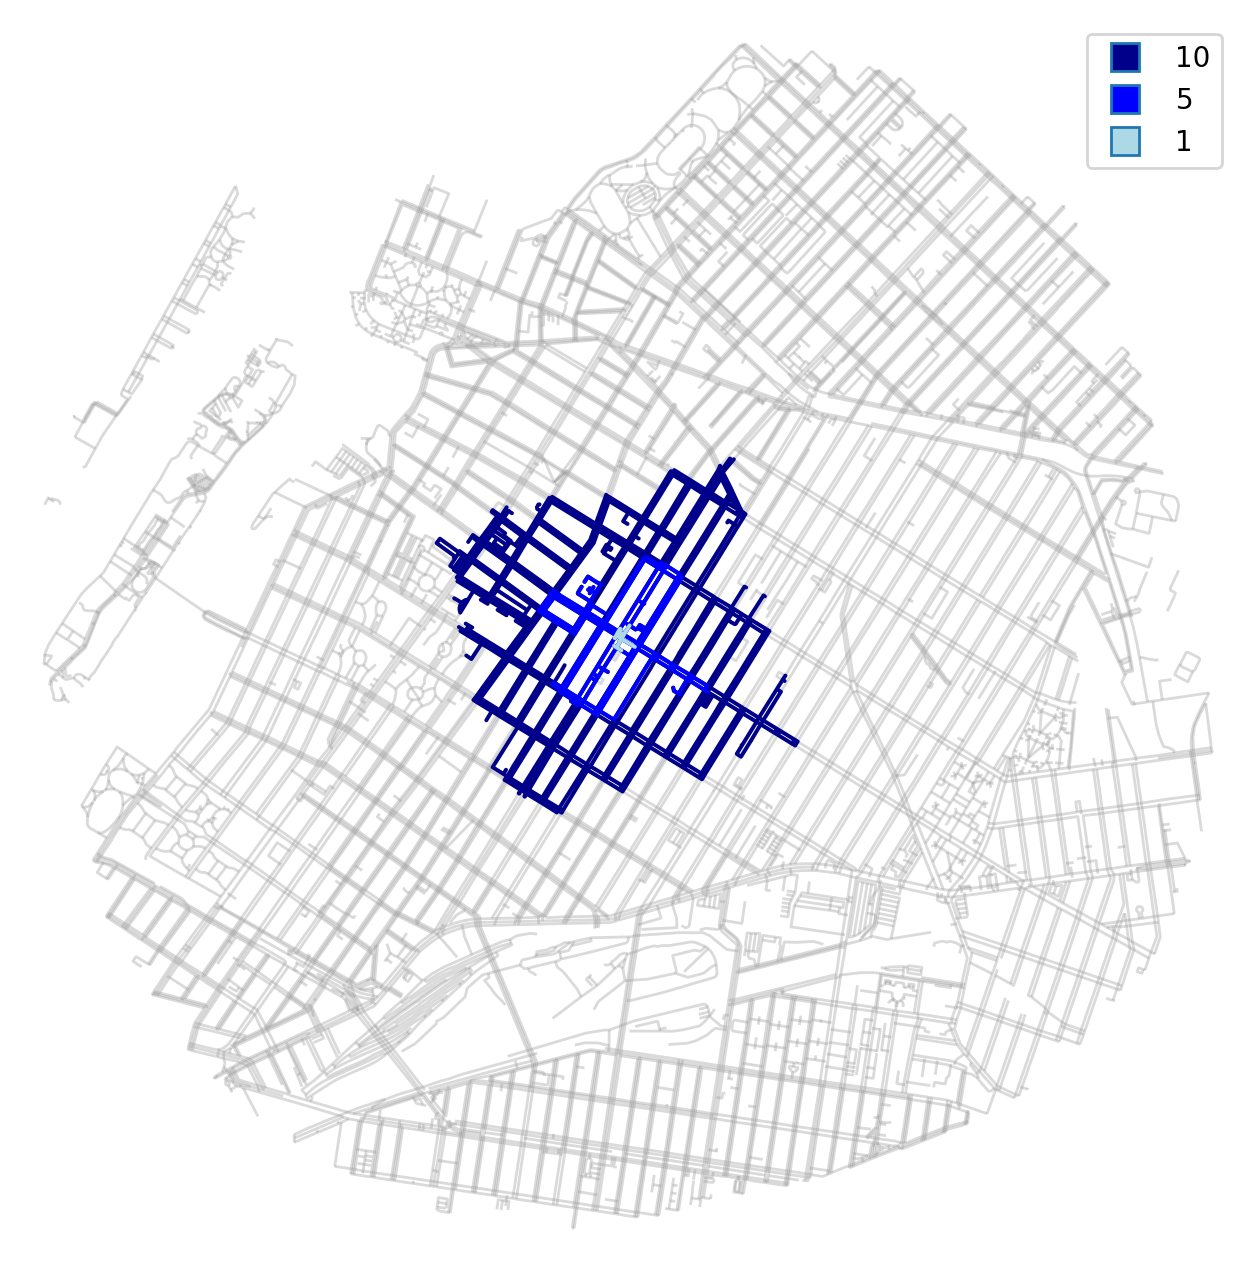

In [60]:
# plot the network then add isochrones as colored descartes polygon patches
fig, ax = ox.plot_graph(
    G_queens,
    show=False,
    close=False,
    edge_color="#999999",
    edge_alpha=0.2,
    node_size=0,
    bgcolor="w",
)
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    isochrone_buffer_gdf[isochrone_buffer_gdf["trip_time"] == trip_time].plot(
        ax=ax, color=color
    )

lines = [
    mlines.Line2D(
        [0], [0], linestyle="none", marker="s", markersize=10, markerfacecolor=color
    )
    for color in iso_colors
]
labels = sorted(trip_times, reverse=True)
ax.legend(lines, labels)
ax.set_axis_off()
plt.show()

## Now let's compare to biking and driving!

In [61]:
if use_local_data:
  G_bike = ox.io.load_graphml(filepath='./nyc_bike.graphml')
  G_drive = ox.io.load_graphml(filepath='./nyc_drive.graphml')
else:
  # download the bike and driving network, this may take a few minutes
  G_bike = ox.graph_from_place(place, network_type="bike")
  G_drive = ox.graph_from_place(place, network_type="drive")

In [62]:
# need to project both!
G_bike = ox.project_graph(G_bike, to_crs=2263)
G_drive = ox.project_graph(G_drive, to_crs=2263)

In [63]:
# making the time values
mode_types = ["bike", "drive"]
graph_list = [G_bike, G_drive]

avg_feet_per_min = {"bike": 880, "drive": 2640}

for mode_type, graph in zip(mode_types, graph_list):
    for u, v, k, data in graph.edges(data=True, keys=True):
        data["length_ft"] = data["length"] * 3.28084  # osmnx internal units are meters
        data["time"] = data["length_ft"] / (
            avg_feet_per_min[mode_type]
        )  # divide by feet per minute

In [64]:
# make the isochrone polygons for bike and driving
# this time we'll iterate through mode
isochrone_polys_by_mode = {
    mode_type: {x: [] for x in trip_times} for mode_type in mode_types
}
for mode_type, graph in zip(mode_types, graph_list):
    for node in tqdm(closest_node):  # note: this loop can also take in a list of nodes
        for trip_time in sorted(trip_times, reverse=True):
            subgraph = nx.ego_graph(graph, node, radius=trip_time, distance="time")
            node_points = [
                Point((data["x"], data["y"]))
                for node, data in subgraph.nodes(data=True)
            ]
            bounding_poly = gpd.GeoSeries(node_points).union_all().convex_hull
            isochrone_polys_by_mode[mode_type][trip_time].append(bounding_poly)
isochrone_polys_by_mode;

  0%|          | 0/1 [00:00<?, ?it/s]


NodeNotFound: Node 3576165300 not found in graph

In [ ]:
# combine all of our isochrones into one dataframe
isochrone_gdf_mode_list = [
    pd.DataFrame.from_dict(isochrone_polys_by_mode[mode], orient="index").assign(
        mode_type=mode
    )
    for mode in mode_types
]
isochrone_gdf_mode = (
    pd.concat(isochrone_gdf_mode_list)
    .reset_index()
    .rename(columns={"index": "trip_time", 0: "geometry"})
)
isochrone_gdf_mode = isochrone_gdf_mode.set_geometry("geometry", crs=2263)
# add in walking isochrones too
isochrone_gdf_mode = pd.concat(
    [isochrone_gdf_mode, isochrone_gdf.assign(mode_type="walk")]
)
isochrone_gdf_mode.head()

In [ ]:
# define a dictionary with the colors for the isochrones
iso_colors_dict = {
    "walk": ["darkgreen", "green", "lightgreen"],
    "bike": ["darkblue", "blue", "lightblue"],
    "drive": ["darkred", "red", "orange"],
}

# for plotting, create a subgraph that is just the street grid surrounding the pt
# we'll make this larger, since the driving isochrone is quite large
queens_nodes = gdf_nodes.clip(isochrone_gdf.buffer(5280 * 8)).index
G_queens = G.subgraph(queens_nodes)
G_queens;

In [ ]:
# plot the network then add isochrones for each mode type
# redefine mode types
# make separate subplots for each mode type (to improve readability)
mode_types = ["drive", "bike", "walk"]
fig, axes = plt.subplots(1, 3, figsize=(30, 8))
for ax, mode_type in tqdm(zip(axes, mode_types)):
    ox.plot_graph(
        G_queens,
        ax=ax,
        show=False,
        close=False,
        edge_color="#999999",
        edge_alpha=0.2,
        node_size=0,
        bgcolor="w",
    )
    for trip_time, color in tqdm(
        zip(sorted(trip_times, reverse=True), iso_colors_dict[mode_type])
    ):
        isochrone_gdf_subset = isochrone_gdf_mode[
            (isochrone_gdf_mode["mode_type"] == mode_type)
            & (isochrone_gdf_mode["trip_time"] == trip_time)
        ]
        isochrone_gdf_subset.plot(ax=ax, color=color)

    lines = [
        mlines.Line2D(
            [0], [0], linestyle="none", marker="s", markersize=10, markerfacecolor=color
        )
        for color in iso_colors_dict[mode_type]
    ]
    labels = [str(i) + "min" for i in sorted(trip_times, reverse=True)]
    ax.legend(lines, labels)
    ax.set_title(mode_type)
    ax.set_axis_off()
plt.show();

#No new homework this week -- exam coming up!